In [1]:
import pandas as pd
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, confusion_matrix
from xgboost import XGBClassifier
import numpy as np
from numpy import NaN
from statistics import mode
from imblearn.over_sampling import SMOTE
import random
random.seed(42)
import warnings
warnings.filterwarnings("ignore")

In [2]:
df = pd.read_csv("../data/loan_data_set.csv")
df.head()

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,LP001002,Male,No,0,Graduate,No,5849,0.0,NaN,360.0,1.0,Urban,Y
1,LP001003,Male,Yes,1,Graduate,No,4583,1508.0,128.0,360.0,1.0,Rural,N
2,LP001005,Male,Yes,0,Graduate,Yes,3000,0.0,66.0,360.0,1.0,Urban,Y
3,LP001006,Male,Yes,0,Not Graduate,No,2583,2358.0,120.0,360.0,1.0,Urban,Y
4,LP001008,Male,No,0,Graduate,No,6000,0.0,141.0,360.0,1.0,Urban,Y


In [3]:
df.drop('Loan_ID', axis=1, inplace=True)

## Checking NaN Values

In [4]:
for i in df.keys():
    print(df[f'{i}'].isnull().value_counts())

False    601
True      13
Name: Gender, dtype: int64
False    611
True       3
Name: Married, dtype: int64
False    599
True      15
Name: Dependents, dtype: int64
False    614
Name: Education, dtype: int64
False    582
True      32
Name: Self_Employed, dtype: int64
False    614
Name: ApplicantIncome, dtype: int64
False    614
Name: CoapplicantIncome, dtype: int64
False    592
True      22
Name: LoanAmount, dtype: int64
False    600
True      14
Name: Loan_Amount_Term, dtype: int64
False    564
True      50
Name: Credit_History, dtype: int64
False    614
Name: Property_Area, dtype: int64
False    614
Name: Loan_Status, dtype: int64


## Spliting Columns based on categorical and numerical

In [5]:
categorical = ['Gender', 'Married', 'Education', 'Self_Employed', 'Credit_History', 'Property_Area', 'Loan_Amount_Term', 'Dependents']
numerical = ['ApplicantIncome', 'CoapplicantIncome', 'LoanAmount']

In [6]:
# As number of NaN values are few in comparision to known values in almost all columns thus replacing categroical values with the most frequent value and regresive values with the mean.
for col in numerical:
    df[f'{col}'].replace(NaN, df[f'{col}'].mean(skipna=True), inplace=True)

for col in categorical:
    df[f'{col}'].replace(NaN, df[f'{col}'].mode()[0], inplace=True)

## Encoding Categorical Values

In [7]:
df["Loan_Status"].replace('Y', 1, inplace=True)
df["Loan_Status"].replace('N', 0, inplace=True)
df['Loan_Status'] = df['Loan_Status'].astype(int)

In [8]:
df["Self_Employed"].replace('Yes', 1, inplace=True)
df["Self_Employed"].replace('No', 0, inplace=True)
df["Self_Employed"] = df["Self_Employed"].astype(int)

In [9]:

male_yes =  len(df[(df['Loan_Status'] == 1) & (df['Gender'] == 'Male')  ])
male_no =   len(df[(df['Loan_Status'] == 0) & (df['Gender'] == 'Male')  ])
female_yes =len(df[(df['Loan_Status'] == 1) & (df['Gender'] == 'Female')])
female_no = len(df[(df['Loan_Status'] == 0) & (df['Gender'] == 'Female')])
male_yes, male_no, female_yes, female_no, male_yes/male_no, female_yes/female_no

(347, 155, 75, 37, 2.238709677419355, 2.027027027027027)

In [10]:
df['Gender'] = pd.get_dummies(df['Gender'])['Male']

In [11]:
df['Dependents'].value_counts()

0     360
1     102
2     101
3+     51
Name: Dependents, dtype: int64

In [12]:
df['Dependents'].replace('3+', 3, inplace=True)
df['Dependents']= df['Dependents'].astype(int)

In [13]:
df['Loan_Amount_Term'].value_counts()

360.0    526
180.0     44
480.0     15
300.0     13
240.0      4
84.0       4
120.0      3
60.0       2
36.0       2
12.0       1
Name: Loan_Amount_Term, dtype: int64

<AxesSubplot:xlabel='Married', ylabel='Count'>

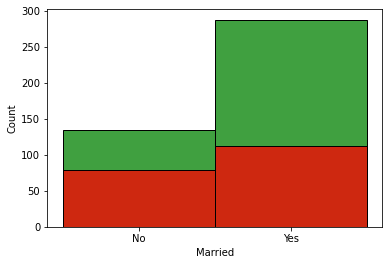

In [14]:
sns.histplot(df[df['Loan_Status'] == 1]['Married'], color='green')
sns.histplot(df[df['Loan_Status'] == 0]['Married'], color='red')

In [15]:
df['Married'] = pd.get_dummies(df['Married'])['Yes']

<AxesSubplot:xlabel='Education', ylabel='Count'>

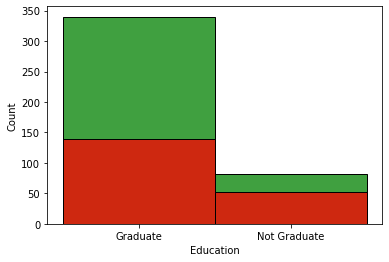

In [16]:
sns.histplot(df[df['Loan_Status'] == 1]['Education'], color='green')
sns.histplot(df[df['Loan_Status'] == 0]['Education'], color='red')

In [17]:
df['Education'] = pd.get_dummies(df['Education'])['Graduate']

<AxesSubplot:xlabel='Property_Area', ylabel='Count'>

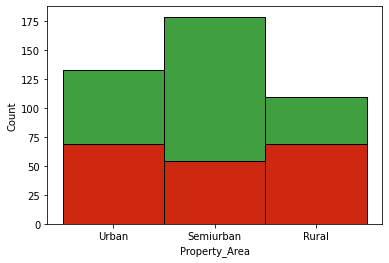

In [18]:
sns.histplot(df[df['Loan_Status'] == 1]['Property_Area'], color='green')
sns.histplot(df[df['Loan_Status'] == 0]['Property_Area'], color='red')

In [19]:
df['Property_Area'].replace('Semiurban', 2, inplace=True)
df['Property_Area'].replace('Urban', 1, inplace=True)
df['Property_Area'].replace('Rural', 0, inplace=True)

In [20]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 614 entries, 0 to 613
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Gender             614 non-null    uint8  
 1   Married            614 non-null    uint8  
 2   Dependents         614 non-null    int64  
 3   Education          614 non-null    uint8  
 4   Self_Employed      614 non-null    int64  
 5   ApplicantIncome    614 non-null    int64  
 6   CoapplicantIncome  614 non-null    float64
 7   LoanAmount         614 non-null    float64
 8   Loan_Amount_Term   614 non-null    float64
 9   Credit_History     614 non-null    float64
 10  Property_Area      614 non-null    int64  
 11  Loan_Status        614 non-null    int64  
dtypes: float64(4), int64(5), uint8(3)
memory usage: 45.1 KB


## Checking Outliers

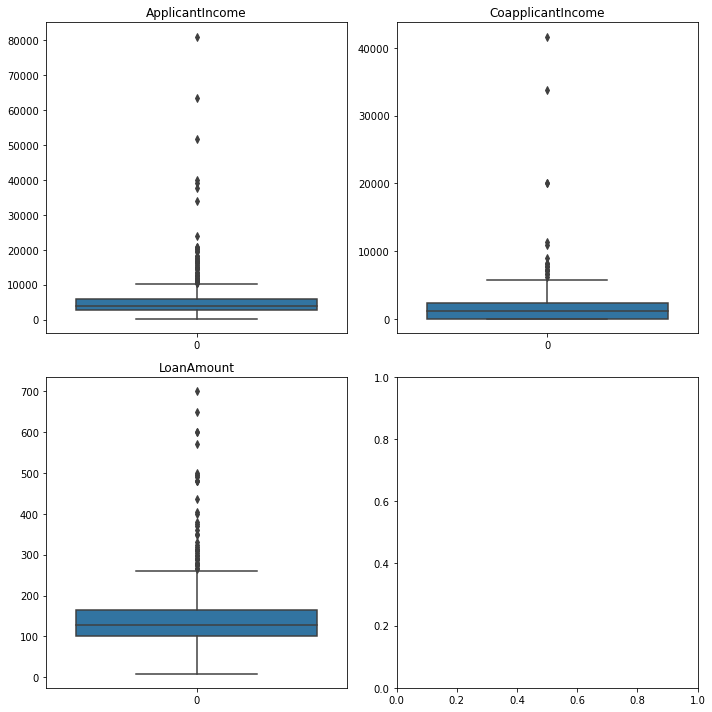

In [21]:
fig, axis = plt.subplots(2, 2, figsize=(10,10))

for id, i in enumerate(numerical):
    sns.boxplot(data=df['{}'.format(i)], ax=axis[id//2, id%2])
    axis[id//2, id%2].set_title(f'{i}')
plt.tight_layout()

## Removing Outliers

In [22]:
Q1 = df[numerical].quantile(0.25)
Q3 = df[numerical].quantile(0.75)
IQR = Q3 - Q1
IQR

ApplicantIncome      2917.50
CoapplicantIncome    2297.25
LoanAmount             64.50
dtype: float64

In [23]:
df[numerical] = df[~((df[numerical] > Q3+1.5*IQR) | (df[numerical] < Q1 - 1.5*IQR))][numerical]
df = df.dropna().reset_index().drop('index', axis=1)
df

,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,1,0,0,1,0,5849.0,0.0,146.412162,360.0,1.0,1,1
1,1,1,1,1,0,4583.0,1508.0,128.000000,360.0,1.0,0,0
2,1,1,0,1,1,3000.0,0.0,66.000000,360.0,1.0,1,1
3,1,1,0,0,0,2583.0,2358.0,120.000000,360.0,1.0,1,1
4,1,0,0,1,0,6000.0,0.0,141.000000,360.0,1.0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...
530,0,0,0,1,0,2900.0,0.0,71.000000,360.0,1.0,0,1
531,1,1,3,1,0,4106.0,0.0,40.000000,180.0,1.0,0,1
532,1,1,1,1,0,8072.0,240.0,253.000000,360.0,1.0,1,1
533,1,1,2,1,0,7583.0,0.0,187.000000,360.0,1.0,1,1


## Checking Skewness
- Application Income and Co Applicant field is left skewed

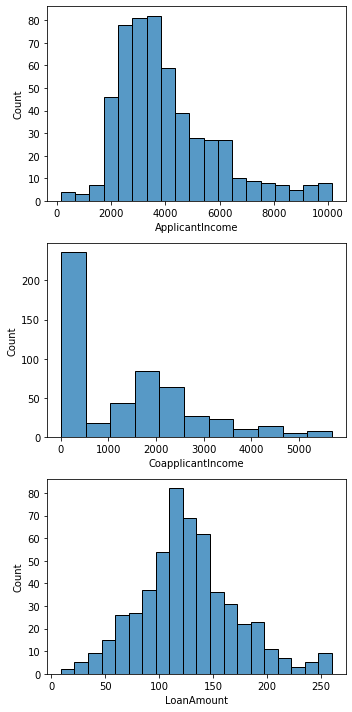

In [24]:
fig, axis = plt.subplots(3, 1, figsize=((5, 10)))
for id, i in enumerate(numerical):
    sns.histplot(data=df['{}'.format(i)], ax=axis[id])
plt.tight_layout()

- Fixing Skewness of using sqrt transformation
- Log transformation is leading to right skewness

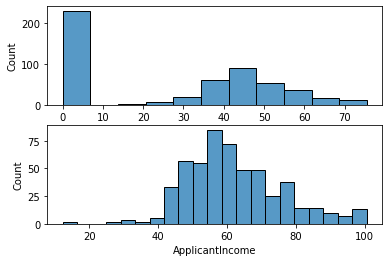

In [25]:
fig, axis = plt.subplots(2,1)
sns.histplot(np.sqrt(df['CoapplicantIncome']), ax=axis[0])
sns.histplot(np.sqrt(df['ApplicantIncome']), ax=axis[1])
plt.show()

- Yep it is fixed :)

In [26]:
df['CoapplicantIncome'], df['ApplicantIncome'] = np.sqrt(df['CoapplicantIncome']), np.sqrt(df['ApplicantIncome'])

In [27]:
df.corr()

,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
Gender,1.000000,0.372519,0.187076,-0.072320,0.021148,0.079306,0.217693,0.148249,-0.079050,0.005714,-0.096797,0.047217
Married,0.372519,1.000000,0.340098,-0.025423,0.016299,-0.005074,0.316334,0.203016,-0.087666,0.008181,0.032102,0.085391
Dependents,0.187076,0.340098,1.000000,-0.082991,0.054542,0.123949,-0.038643,0.114099,-0.092739,-0.032058,0.031361,0.008150
Education,-0.072320,-0.025423,-0.082991,1.000000,-0.000869,0.143617,-0.010257,0.117899,0.073561,0.085002,0.079451,0.114159
Self_Employed,0.021148,0.016299,0.054542,-0.000869,1.000000,0.170589,-0.082500,0.087663,-0.064348,0.031554,-0.000936,-0.005302
ApplicantIncome,0.079306,-0.005074,0.123949,0.143617,0.170589,1.000000,-0.339271,0.459540,-0.066839,0.044169,-0.024648,0.012179
CoapplicantIncome,0.217693,0.316334,-0.038643,-0.010257,-0.082500,-0.339271,1.000000,0.244993,0.015383,0.007661,-0.044190,0.085841
LoanAmount,0.148249,0.203016,0.114099,0.117899,0.087663,0.459540,0.244993,1.000000,0.087457,0.008066,-0.014546,-0.020474
Loan_Amount_Term,-0.079050,-0.087666,-0.092739,0.073561,-0.064348,-0.066839,0.015383,0.087457,1.000000,-0.017483,0.020529,-0.025424
Credit_History,0.005714,0.008181,-0.032058,0.085002,0.031554,0.044169,0.007661,0.008066,-0.017483,1.000000,0.042290,0.566580


## Checking Imbalance
- Number of approved Loans are much more than Number of approved Loans

<AxesSubplot:xlabel='Loan_Status', ylabel='Count'>

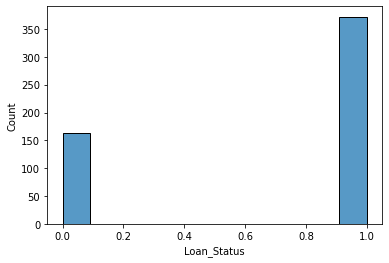

In [28]:
sns.histplot(df['Loan_Status'])

## Splitting into training and testing then using SMOTE to rectify class imbalance

In [29]:
X_train, X_test, y_train, y_test = train_test_split(df[list(df.keys().drop('Loan_Status'))], df['Loan_Status'], test_size=0.2, random_state=42)
X_train, y_train = SMOTE().fit_resample(X=X_train, y=y_train)

## Using XGBoost and checking the appropriate value of max_depth parameter

In [30]:
precision = []
recall = []
macc = []
f1 = []
for max_depth in range(3, 15):
    XGBclassifier = XGBClassifier(n_estimators = 1000, max_depth = max_depth, learning_rate = 0.03, objective = 'binary:logistic', eval_metric = 'auc')
    XGBclassifier.fit(X_train, y_train)
    xyz = XGBclassifier.predict(X_test)
    precision.append(precision_score(y_test, xyz))
    recall.append(recall_score(y_test, xyz))
    f1.append(f1_score(y_test, xyz))
    macc.append(accuracy_score(y_test, xyz))

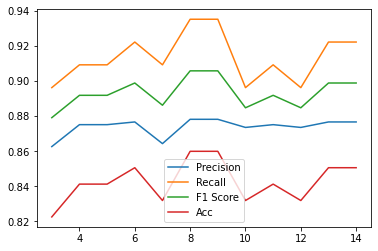

In [31]:
X = np.arange(3, 15)
plt.plot(X[:12], precision[:12], label = 'Precision')
plt.plot(X[:12], recall[:12], label = 'Recall')
plt.plot(X[:12], f1[:12], label = 'F1 Score')
plt.plot(X[:12], macc[:12], label = 'Acc')
plt.legend()

In [32]:
max_depth = mode([3+np.argmax(f1), 3+np.argmax(precision), 3+np.argmax(macc), 3+np.argmax(recall)])
max_depth

8

## Training XGBoost over training data

In [33]:
XGBclassifier = XGBClassifier(n_estimators = 1000, max_depth = max_depth, learning_rate = 0.03, objective = 'binary:logistic', eval_metric = 'auc')
XGBclassifier.fit(X_train, y_train)
y_pred = XGBclassifier.predict(X_test)
print(confusion_matrix(y_test, y_pred))
"""Confusion Matrix
TP FP
FN TN
"""
print(f"precision_score: {precision_score(y_test, y_pred)}\nrecall_score: {recall_score(y_test, y_pred)}\nf1_Score: {f1_score(y_test, y_pred)}\naccuracy_score: {accuracy_score(y_test, y_pred)}")

[[20 10]
 [ 5 72]]
precision_score: 0.8780487804878049
recall_score: 0.935064935064935
f1_Score: 0.9056603773584906
accuracy_score: 0.8598130841121495


In [34]:
with open('../models/model.bin', 'wb') as f_out:
    pickle.dump((XGBclassifier), f_out)

## Results:
- Precision is 0.875
- Recall is 0.909
- At time of Bull Market the lenders can handle bad clients as long as the vast majority of applicants payback their credit.In this case, having a good recall (sensitivity) score is prefered.
- At time of Bear Market the lenders prefer a smaller number of good clients even if it means that some good clients where denied credit, and prevent any bad client. In this case, having a good precision score is prefered.

## End!